# Air Quality and Health Risk Forecaster

In [23]:
%pip install pandas seaborn matplotlib xgboost shap
%pip install scikit-learn
# Tell Jupyter to automatically reload modules before executing code (avoids having to manually reload every time I edit helper functions)
%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

This project is in response to the following optimization problem:

"Urban air pollution and fluctuating weather conditions have a direct impact on public health, especially in major cities where population density and pollution levels are high. Your task is to develop a predictive model that can assess the health risk of residents based on air quality (PM2.5, NO2, CO2) and weather conditions (temperature, humidity, wind, etc.) in various U.S. cities.

The goals and requirements of this study are as follows:

1.	Create a predictive model that accurately forecasts air quality levels based on weather conditions and pollution metrics (PM2.5, NO2, CO2).

2.	Develop a highly efficient predictive model that assesses health risks based on urban air quality, weather data, and other relevant factors.

You will implement the chosen models for both urban air quality forecasting and health risk prediction and evaluate their performance using appropriate metrics such as RMSE, MAPE, and trend analysis. Ensure that the models accurately capture the relationships between weather conditions, pollution metrics, and health outcomes and assess their effectiveness across different time periods and urban areas."

In this notebook, I will build, train, and optimize a machine learning solution for this problem.

## Determining the Dependent Variables

The first step is to select features to serve as the dependent variables. Because the request is for a model that can forecast both air quality and health risk, two dependent variables are needed. To determine which features are appropriate for this, inspect the features that are in the dataset:

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Necessary for handling the import of the helper methods
import sys
sys.path.append("..")
from model_methods.implement_initial_model import implement_initial_model
from model_methods.optimize_model import optimize_model
from evaluation_methods.calculate_feature_importance import calculate_feature_importance
from evaluation_methods.create_bar_graphs import create_bar_graphs
from evaluation_methods.shap_analysis import shap_analysis
from sklearn.model_selection import train_test_split

PATH = "../data/raw/DQN1 Dataset.csv"
df = pd.read_csv(PATH)
print(df.columns)

Index(['datetimeEpoch', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'pm2.5', 'no2', 'co2', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed',
       'winddir', 'pressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunriseEpoch', 'sunsetEpoch',
       'moonphase', 'tempRange', 'heatIndex', 'severityScore', 'month',
       'dayOfWeek', 'isWeekend', 'healthRiskScore'],
      dtype='object')


The dataset contains a healthRiskScore feature that can used to measure health risk. However, there is no singular feature for measuring air quality. There are, however, three pollutant features: pm2.5, no2, and co2. Since the problem statement references these in connection with air quality, it makes sense to apply some feature engineering to create a composite "air quality" feature from the individual pollutant values.

For my initial model implementation, I will take a simple average of the pollutant values and analyze how that performs.

In [25]:
# Measure air quality by taking the average of pm2.5, no2, and co2.
df["airQuality"] = df[["pm2.5", "no2", "co2"]].mean(axis=1)

## Exploring Feature Types

Next, I want to examine the datatype of each feature in the dataset.

In [26]:
print(df.dtypes)

datetimeEpoch        int64
tempmax            float64
tempmin            float64
temp               float64
feelslikemax       float64
feelslikemin       float64
feelslike          float64
pm2.5              float64
no2                float64
co2                float64
dew                float64
humidity           float64
precip             float64
precipprob         float64
precipcover        float64
windgust           float64
windspeed          float64
winddir            float64
pressure           float64
cloudcover         float64
visibility         float64
solarradiation     float64
solarenergy        float64
uvindex            float64
severerisk         float64
sunriseEpoch         int64
sunsetEpoch          int64
moonphase          float64
tempRange          float64
heatIndex          float64
severityScore      float64
month                int64
dayOfWeek            int64
isWeekend             bool
healthRiskScore    float64
airQuality         float64
dtype: object


All of the features are numeric except for isWeekend, which is boolean. I am going to use XGBoost for this project, and newer version of XGBoost handle categorical variables well, so I don't necessarily *have* to one-hot encode this feature. However, doing so will give me the flexibility to experiment with other models later if I choose to. Also, because isWeekend is boolean, there are only two categories, so adding sparsity is less of a concern than it might be if there were more categories. Therefore, I will go ahead and one-hot encode this feature.

In [27]:
# This handles isWeekend by converting it to one-hot encoding. drop_first = True
# is needed because we don't need a column for both True and False.
df_numeric = pd.get_dummies(df, drop_first = True) 

## Choice of Model

For this task, I will use XGBoost. I believe that for this particular problem, XGBoost’s speed and accuracy outweigh any concerns around its complexity or interpretability.

The problem description above specifies two components of this optimization problem: 

1. Forecast air quality based on weather conditions and pollution metrics. 
2. Assess health risks based on urban air quality, weather data, and other relevant factors.

The goal is to develop a model that optimizes the prediction of both air quality and health risk scores using the provided dataset. These are continuous features, so this is a regression problem, not a classification problem. XGBoost is designed to handle tasks that require continuous numeric prediction, making it ideally suited for regression problems of this nature [1]. 

Additionally, the problem statement mentions evaluating the model's performance based on metrics such as RMSE and MAPE. XGBoost can quickly provide these and many other metrics to assess its performance, meaning it is well-equipped to provide a robust analysis of the algorithm’s performance. Furthermore, XGBoost provides an extensive set of hyperparameters that can be tuned to improve the results [2]. Consequently, it will offer significant room for experimentation to optimize performance. Finally, the problem statement requests a “highly efficient predictive model”. XGBoost utilizes parallel processing to analyze large datasets quickly [3], enabling it to handle large urban datasets more efficiently than traditional sequential boosting methods. Thus, XGBoost is a highly efficient predictive model.

## Implementation of Initial Models

In [28]:
# Dependent variables for each model
AIR_QUALITY_Y = "airQuality"
HEALTH_RISK_Y = "healthRiskScore"

# Model 1: Build, train, and run the baseline Air Forecaster model.
air_model, air_rmse, air_mape = implement_initial_model(df_numeric, AIR_QUALITY_Y)

# Model 2: Build, train, and run the baseline Health Risk Score model.
health_model, health_rmse, health_mape = implement_initial_model(df_numeric, HEALTH_RISK_Y)

## Evaluation of Initial Models

Since they are specifically mentioned in the problem statement, the two evaluation metrics I’m using are Root Mean Squared Error (“RMSE”) and Mean Absolute Percentage Error (“MAPE”). These two metrics provide two different but equally valuable ways to visualize my model’s errors. RMSE displays errors in the same units as the dependent variable, which makes it easy to visualize how far off the model is [4]. In contrast, MAPE displays errors as a percentage value, making comparison easier [4]. That is particularly useful here, since I will have two models: one to forecast air quality and one to predict health risk. 

The downside to RMSE and MAPE is that both are sensitive to outliers. RMSE significantly penalizes large errors, which can be helpful, but can also result in those errors dominating the metric [4]. MAPE tends to punish negative outliers more than positive ones [4]. This often results in forecasts that are too low [5]. I will need to keep these sensitivities in mind as I implement and optimize my model.

In [29]:
# Print the results for both baseline models.
print(f"Baseline Air Quality Forecaster RMSE: {air_rmse}")
print(f"Baseline Air Quality Forecaster MAPE: {air_mape}")
print(f"Baseline Health Risk Forecaster RMSE: {health_rmse}")
print(f"Baseline Health Risk Forecaster MAPE: {health_mape}")

Baseline Air Quality Forecaster RMSE: 0.8250745403879898
Baseline Air Quality Forecaster MAPE: 0.0035825125937907452
Baseline Health Risk Forecaster RMSE: 0.12317775490090055
Baseline Health Risk Forecaster MAPE: 0.009195693279249812


The low MAPE scores for both models are promising, indicating that the baseline model is already performing well. However, the RMSE for the air quality model is significantly higher than the RMSE for the health risk model, whereas the MAPE for the air quality model is lower. The higher RMSE may be due to the raw values for the pollutants that were averaged to compute air quality being much larger than the raw values for healthRiskScore. When creating my air quality feature, I simply averaged the pollutant values without exploring those features in any depth. I need to explore these features in more detail to 1) better understand the performance of my initial models and 2) determine whether taking a simple average of the pollutant values is a valid way to calculate air quality.

## Exploratory Data Analysis

The below code prints the basic descriptive statistics and produces histograms showing the distributions of the respective pollutant variables.

--- Descriptive Statistics ---
             pm2.5          no2          co2
count  1000.000000  1000.000000  1000.000000
mean     32.737480    30.311160   446.955880
std       6.312905     4.801367    25.910237
min      11.740000    12.400000   381.200000
25%      28.355000    27.030000   427.755000
50%      32.695000    30.130000   447.145000
75%      37.282500    33.740000   465.225000
max      52.380000    42.660000   523.640000
Distributions saved.


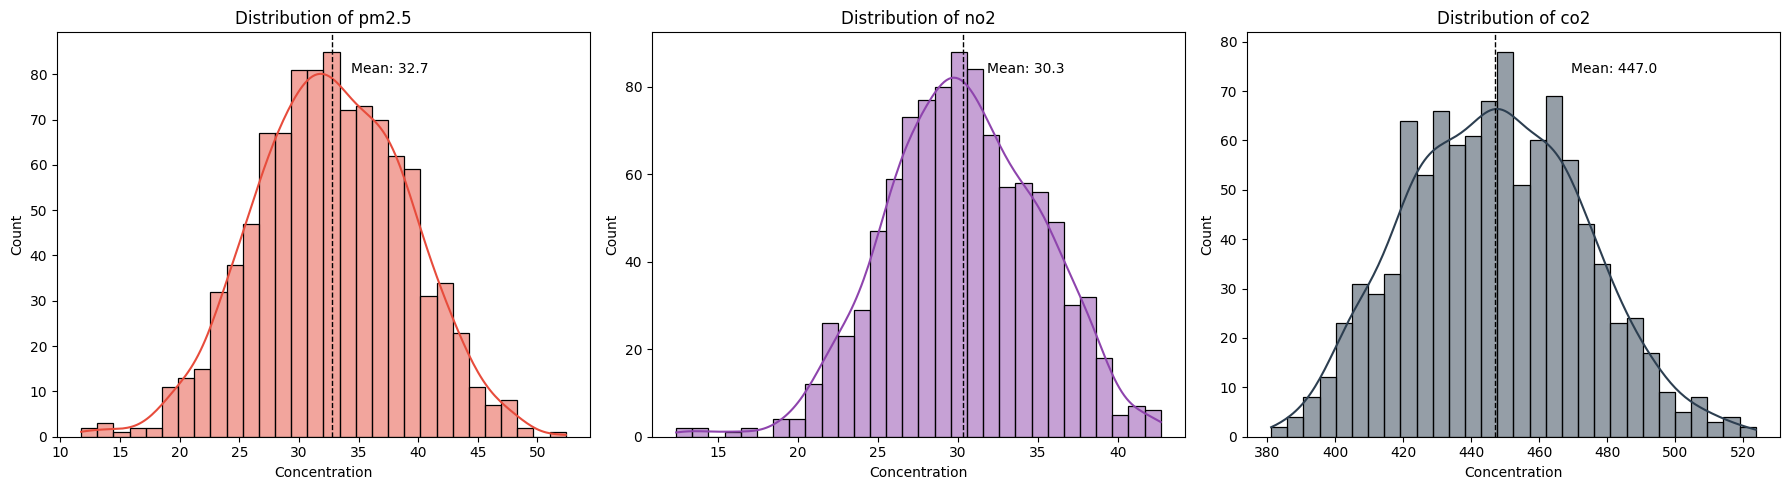

In [30]:
pollutants = ["pm2.5", "no2", "co2"]

print("--- Descriptive Statistics ---")
print(df_numeric[pollutants].describe())

fig, axes = plt.subplots(1, 3, figsize = (18, 5))

colors = ["#e74c3c", "#8e44ad", "#2c3e50"] 

# Plot a histogram showing the distribution of each pollutant
for i, var in enumerate(pollutants):
    sns.histplot(df_numeric[var], kde = True, ax = axes[i], color = colors[i], bins = 30)
    
    # Calculate mean for annotation
    mean_val = df_numeric[var].mean()

    axes[i].axvline(mean_val, color = "k", linestyle = "--", linewidth = 1)
    axes[i].text(mean_val * 1.05, axes[i].get_ylim()[1] * 0.9, f"Mean: {mean_val:.1f}")
    
    axes[i].set_title(f"Distribution of {var}")
    axes[i].set_xlabel("Concentration")

plt.tight_layout()
plt.savefig("../visualizations/pollutant_dist.png")
print("Distributions saved.")


A notable trend evident in these statistics is that co2 values are much larger, in absolute terms, than pm2.5 and no2 values. The pm2.5 and no2 features have similar means (32.7 and 30.3, respectively), but co2’s mean is 447.0. This is about fourteen times larger than the means of the other two pollutant features. Moreover, the standard deviation of the co2 feature (~25.9) is nearly as large as the mean of the other pollutants. 

This also likely explains why the RMSE was much higher for air quality than for health risk. The descriptive statistics for healthRiskScore confirm this.

In [31]:
print("--- healthRiskScore Descriptive Statistics ---")
print(df_numeric["healthRiskScore"].describe())

--- healthRiskScore Descriptive Statistics ---
count    1000.000000
mean        9.729120
std         0.679734
min         8.490000
25%         9.200000
50%         9.550000
75%        10.242500
max        11.490000
Name: healthRiskScore, dtype: float64


The mean of the healthRiskScore is only ~9.7, significantly less than the mean of each pollutant feature.

This scaling issue with my pollutant features indicates my initial approach of calculating air quality by simply averaging these three features was not appropriate. The large co2 values dominated the average, creating a misleading measure of air quality that weakened the model’s analysis. Any approach that treats these features as mathematically equal will be mathematically biased toward co2. 

A better approach might be to normalize the values of these features before taking the average. However, before I do that, I want to take a brief look at the correlation among these features.

In [32]:
# Print the correlation matrix of the pollutants
print("--- Correlation Matrix ---")
print(df_numeric[pollutants].corr())

--- Correlation Matrix ---
          pm2.5       no2       co2
pm2.5  1.000000  0.544206  0.550005
no2    0.544206  1.000000  0.523929
co2    0.550005  0.523929  1.000000


The correlation matrix indicates a consistent, moderate positive correlation among all three pollutant features. This correlation suggests that the pollutants may originate from a shared source, causing them to rise and fall together, and that they are likely manifestations of a single underlying factor.

This justifies my decision to combine them into a single feature by taking the normalized average, as combining features is a common technique for addressing multicollinearity [6]. This is particularly true given the correlation levels present here. If the pollutants were correlated with one another at a much higher level (say, greater than 0.9), I could just use one of them and drop the other two. There would be no need to combine them. On the other hand, if there were no correlation at all, it would not make sense to average them, as doing so could lead to information loss. However, correlation levels of ~0.5 represent a sweet spot. They indicate that each pollutant feature is conveying enough unique information to militate against dropping it, but not so much that something important will be lost if they are combined into a composite air quality feature. Thus, creating a composite feature from the normalized averages of these pollutants makes sense.

## Creating an Optimized Air Quality Feature

Below, I create a better air quality feature by taking the normalized average of the pollutant features.

In [33]:
scaler = MinMaxScaler()
# Create normalized verions of the pollutant features
df_numeric[["pm2.5_norm", "no2_norm", "co2_norm"]] = scaler.fit_transform(
    df_numeric[["pm2.5", "no2", "co2"]]
)
# Take the average of the normalized pollutant features
df_numeric["airQualityOptimized"] = df_numeric[["pm2.5_norm", "no2_norm", "co2_norm"]].mean(axis = 1)
# Confirm normalization was successful
print(df_numeric["airQualityOptimized"].describe())

count    1000.000000
mean        0.523406
std         0.137658
min         0.067210
25%         0.425646
50%         0.521425
75%         0.610331
max         0.885590
Name: airQualityOptimized, dtype: float64


Now air quality is measured on a 0-to-1 scale with a mean of ~0.52. No single pollutant is dominating the measurement.

Since the original air quality feature is no longer needed, drop it from the dataframe.

In [34]:
# Drop the first composite air quality feature I initially created
df_numeric = df_numeric.drop("airQuality", axis = 1)
# Confirm original air quality column was dropped successfully
print(df_numeric.columns)


Index(['datetimeEpoch', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'pm2.5', 'no2', 'co2', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed',
       'winddir', 'pressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunriseEpoch', 'sunsetEpoch',
       'moonphase', 'tempRange', 'heatIndex', 'severityScore', 'month',
       'dayOfWeek', 'isWeekend', 'healthRiskScore', 'pm2.5_norm', 'no2_norm',
       'co2_norm', 'airQualityOptimized'],
      dtype='object')


## Addressing Data Leakage

Another critical issue that likely affected my initial models is data leakage. After creating the initial composite air quality feature, I did not drop the individual pollutant features from the dataframe. This means that there is a high probability that data leakage affected the performance of my initial air quality model. An RMSE of ~0.82 on a feature that has a mean value in the low triple digits is actually quite low. The MAPE for the air quality model was also three times lower than the MAPE of the health risk model. There is a significant chance that these metrics are artificially low because of data leakage. XGBoost is a sophisticated model. It likely learned that it could simply predict air quality by averaging the individual pollutants.

initial_air_quality Feature Importance Chart Saved


<Figure size 1000x600 with 0 Axes>

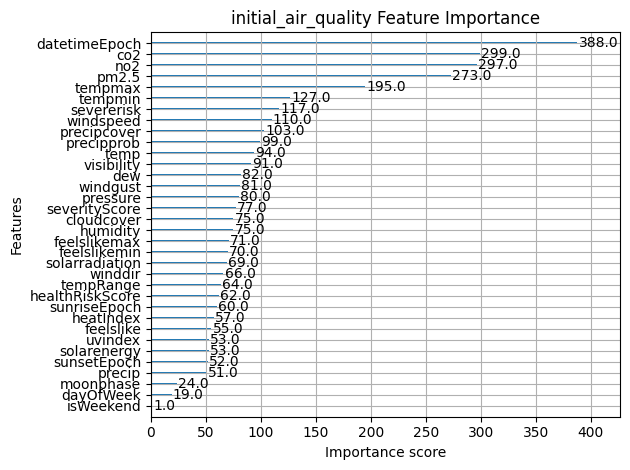

In [35]:
calculate_feature_importance(air_model, "initial_air_quality")

The feature importance scores confirm this. 3 of the top 4 most important features are the individual pollutants. To address this data leakage issue, I will drop the individual pollutant features (and the normalized versions I just created) from the dataframe.

In [36]:
# To prevent data leakage, drop the columns used to create the composite air
# quality feature
cols_to_drop = ["pm2.5", "no2", "co2", "pm2.5_norm", "no2_norm", "co2_norm"]
df_numeric = df_numeric.drop(columns = cols_to_drop)

# Save the processed and cleaned dataset
df_numeric.to_csv("../data/processed/processed_dataset.csv", index = False)

## Model Optimization

I'm now ready to move to model optimization. XGBoost offers a wide array of options for hyperparameter tuning, but this can be a double-edged sword. It offers susbstantial flexibility, but also means that some difficult choices have to be made. I will choose a sampling of ensemble, regularization, and optimization techniques and run a grid search to analyze all possible combinations of them.

**Optimization Technique - Apply Shrinkage**

The first optimization technique I chose was to use the learning_rate parameter to apply “shrinkage” to the size of the steps my algorithm takes toward the minimum. I decided to do this because a common risk of gradient boosting machine learning algorithms is overshooting the minimum [7], which results in the algorithm failing to discover the optimal model. The likelihood of falling victim to this pitfall can be reduced by shrinking the algorithm’s step size, which can be achieved by modifying the learning_rate parameter [7]. The opposite problem is also a concern: if the step size is too small, the algorithm may get stuck at a local minimum [7], which appears to be the optimal model but is not. Thus, it is also important not to reduce the step size too drastically. This is where a grid search excels, and where my two primary optimization techniques complement each other. Using a grid search, I experimented with multiple learning rates to determine which one performed best.

**Ensemble Techniques Boosting and Bagging (Subsampling)**

XGBoost contains a built-in ensemble learning technique via its use of multiple decision trees. The model’s performance can be affected by the number of trees it uses. Too few trees can lead to underfitting, but too many trees can lead to overfitting (in addition to slower training and prediction, which violates the problem statement's requirement for a highly efficient model) [8]. Thus, it seemed logical to experiment with the number of trees added to the model as my first ensemble learning technique. To accomplish this, I added a couple of different values for the n_estimators hyperparameter to my grid search.

For my second ensemble learning technique, I used “bagging” by adding the subsample hyperparameter to my Grid Search. I chose this technique because it helps accomplish three different goals. First, the problem statement emphasizes that the model should be accurate. Bagging reduces overfitting to the training data by training each tree on a subset of the data rather than the whole dataset, thereby improving the model’s accuracy on the test data [9]. Second, by training the various trees on different subsets of the data, bagging often improves the model’s generalization [9]. Finally, the problem statement specifies that the model must be efficient. Since the whole dataset is not being used for each tree, bagging speeds up the model’s training process.

**Regularization Techniques - L1 and L2 Regularizations**

For my regularization techniques, I chose to apply L1 (Lasso) Regularization (via the reg_alpha hyperparameter) and L2 (Ridge) Regularization (via the reg_lambda hyperparameter). I chose these because they are two of the most common methods for preventing overfitting in multiple regression models [10]. Additionally, they offer contrasting approaches to regularization. 

L1 Regularization encourages feature sparsity by applying a penalty that drives some coefficients to zero [11]. This further helps my model satisfy the problem statement's efficiency requirements by placing more emphasis on the most salient features while deemphasizing features that are irrelevant or redundant.

In contrast, L2 Regularization tends to reduce feature coefficients more uniformly [10]. This is particularly effective for handling datasets where independent variables are highly correlated [12]. Because the dataset comprises numerous weather-related features, it is likely that some of these features are highly correlated with each other. Thus, Ridge Regression is a suitable fit for the dataset, helping to ensure the model accurately captures the relationships among the different features as requested in the problem statement.

I also added a third regularization technique via max_depth. A common source of overfitting in tree models is overly deep/complex trees [13]. By using max_depth to cap the depth of the model's trees, I can mitigate this tendency and further regularize the model to make it more generalizable.



In [37]:
# Parameters to test during the grid search
PARAM_GRID = {
    # ENSEMBLE TECHNIQUE 1: BOOSTING (n_estimators controls the number of boosting
    # rounds)
    "n_estimators": [100, 200],
    # ENSEMBLE TECHNIQUE 2: BAGGING (SUBSAMPLING) (using < 1.0 means the model is
    # using Bagging/Stochastic Boosting)
    "subsample": [0.8, 0.9],
    # REGULARIZATION TECHNIQUE 1: L1 (LASSO) REGULARIZATION   
    "reg_alpha": [0.1, 0.5],     
    # REGULARIZATION TECHNIQUE 2: L2 (RIDGE) REGULARIZATION   
    "reg_lambda": [0.1, 0.5],
    # OPTIMIZATION TECHNIQUE: SHRINKAGE VIA LEARNING RATE (slow down learning
    # rate to avoid overshooting the optimal model)            
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5]
}

### Model Optimization - Air Quality

Note that below, I also drop healthRiskScore from the air quality model because it seems circular to predict air quality from health risk.

In [38]:
print("\n=== OPTIMIZING AIR QUALITY MODEL ===")
    
# It doesn't really make sense to predict air quality from health risk.
# Generally, health risk is predicted from air quality, not the other way 
# around. So drop the healthRiskScore feature
X_air = df_numeric.drop(columns=["airQualityOptimized", "healthRiskScore"]) 
y_air = df_numeric["airQualityOptimized"]

# Split (use the same random_state for fair comparison)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_air, y_air, test_size = 0.2, random_state = 42
)

# Run a grid search on the model using the various parameters specified above to determine the most optimal model
opt_air, opt_air_rmse, opt_air_mape, opt_air_params = optimize_model(
    X_train_a, y_train_a, X_test_a, y_test_a, PARAM_GRID
)

print(f"Optimized Air Quality RMSE: {opt_air_rmse}")
print(f"Optimized Air Quality MAPE: {opt_air_mape}")


=== OPTIMIZING AIR QUALITY MODEL ===
Starting Grid Search...
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters Found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Optimized Air Quality RMSE: 0.06603924666446008
Optimized Air Quality MAPE: 0.1071989679406081


### Model Optimization - Health Risk

I do, however, use air quality as a predictor of health risk.

In [39]:
print("\n=== OPTIMIZING HEALTH RISK MODEL ===")
    
# It does make sense to use air quality as a predictor for health risk, so 
# while dropping healthRiskScore from the Air Quality Model above made sense,
# it does not make sense to drop the pollutant features or the custom
# airQuality_optimized feature I created above from my Health Risk Model
X_health = df_numeric.drop(columns=["healthRiskScore"])
y_health = df_numeric["healthRiskScore"]

# Split (use the same random_state for fair comparison)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_health, y_health, test_size = 0.2, random_state = 42
)

# Run a grid search on the model using the various parameters specified above 
# to determine the most optimal model
opt_health, opt_health_rmse, opt_health_mape, opt_health_params = optimize_model(
    X_train_h, y_train_h, X_test_h, y_test_h, PARAM_GRID
)

print(f"Optimized Health Risk RMSE: {opt_health_rmse}")
print(f"Optimized Health Risk MAPE: {opt_health_mape}")


=== OPTIMIZING HEALTH RISK MODEL ===
Starting Grid Search...
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.8}
Optimized Health Risk RMSE: 0.11241926436051096
Optimized Health Risk MAPE: 0.008804837814657327


## Model Evaluation and Analysis

### MAPE and RMSE Comparisons

The code below generates bar charts to compare the models' performance before and after optimization with respect to both evaluation metrics (RMSE and MAPE).

The first things that jump out about these charts are: 1) the massive improvement in air quality RMSE , and 2) the massive increase in air quality MAPE . However, both of these observations are misleading, for different reasons.

First, RMSE measures error in the same units/scale as the dependent variable. Thus, if the dependent variable has large values, RMSE is likely to be larger. This is significant here because, as previously discussed, I performed feature engineering to normalize the pollutant values before averaging them, ensuring that each pollutant is weighted equally when calculating air quality. This resulted in much smaller raw air quality scores than were used for the baseline model. Consequently, much of the significant decrease in air quality RMSE can be attributed to this change in the calculation method for air quality. This makes it difficult to directly compare the baseline vs optimized RMSE values with respect to air quality. However, this is outweighed by the gains in accuracy achieved by using a measure of air quality that equally weights all pollutants. Ultimately, with feature engineering, the optimized model provides a more robust prediction of air quality by fully factoring in the impact of all pollutants, which is essential to ensuring the model achieves the problem statement’s goal of accurately forecasting air quality based on weather and pollution metrics.

Second, the significant increase in air quality MAPE over the baseline model is misleading due to data leakage. As discussed above, the individual pollutant features that were averaged to create the composite air quality feature were not dropped from the initial air quality model. This created a substantial data leak that heavily skewed the results of the baseline model regarding air quality. XGBoost is a sophisticated algorithm, and with both the individual pollutant features and the composite air quality feature included in the dataframe, it quickly learned that it could predict air quality with a high degree of accuracy simply by examining the individual pollutant features that were averaged together to calculate the composite air quality feature. This resulted in an artificially tiny MAPE and RMSE (although the baseline air quality RMSE is large compared to the optimized model because of the feature engineering, it is small relative to the scale of the baseline air quality feature). Consequently, the large increase in MAPE does not mean that the optimized model is worse. Instead, it is another indication that the optimized model is more “honest” with respect to its air quality predictions, because it is not simply relying on a data leak to predict air quality perfectly based on its component features.

With respect to health risk, the direct comparison of the optimized model to the baseline is much more straightforward. Because no changes were made to the healthRiskScore feature, and that feature does not have the same data leakage concerns as the air quality feature, comparing baseline vs optimized performance does not suffer from the same issue with respect to health risk as it does with regard to air quality. The results are promising. The optimized model reduced the health risk RMSE by approximately 8.74% and decreased the health risk MAPE by approximately 4.35%. These gains are modest but encouraging. Notably, because the problem statement emphasizes efficiency, I limited each hyperparameter in my grid search to two values to ensure its runtime would be reasonable. The performance gains realized by the optimized model suggest that additional gains might be achieved by expanding the grid search to test additional hyperparameter values. For instance, the grid search revealed that for health risk, the best value for the n_estimators hyperparameter is 200, which is the highest value for that hyperparameter that I included in the grid search. This suggests that increasing n_estimators further could yield additional performance improvements.

In summary, the optimized model yielded more accurate and reliable air quality forecasts by applying feature engineering and preventing data leakage. It also resulted in more precise health risk predictions, as evidenced by its improved RMSE and MAPE scores with respect to health risk. Its performance suggests that further improvements could be realized through additional hyperparameter experimentation. Therefore, a logical next step to improve this model might be to perform a more robust grid search to determine how much more accurate the model can be. However, any such additional grid search must be balanced against the problem statement’s emphasis on efficiency. 

Chart saved as 'model_comparison_chart.png'


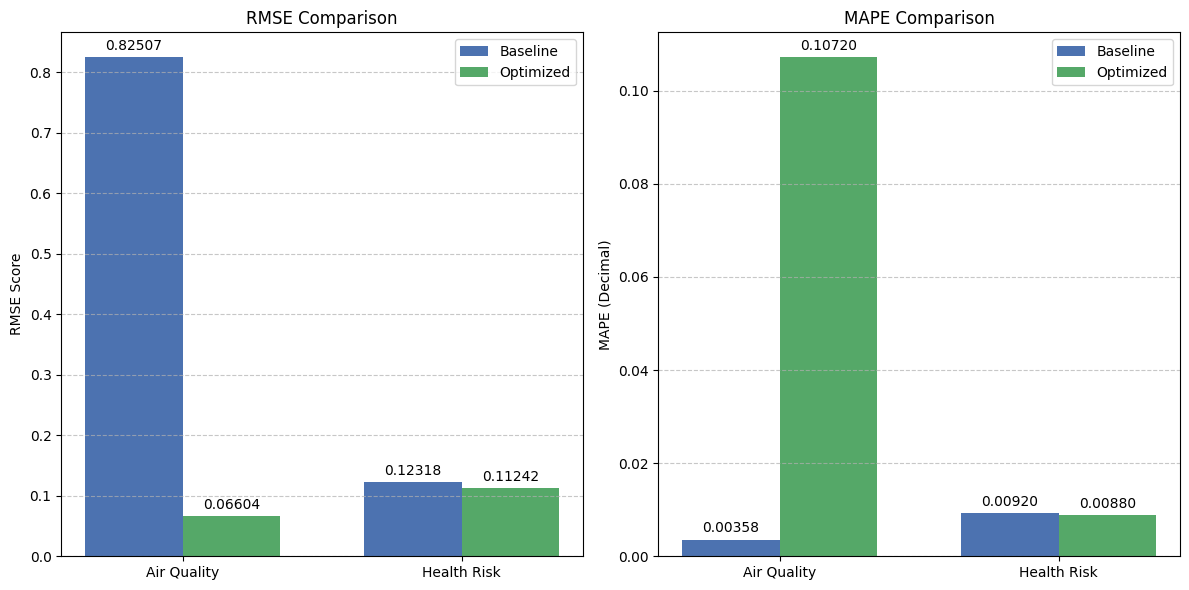

In [40]:
# Create bar graphs to compare baseline vs optimized models
create_bar_graphs(
    [air_rmse, health_rmse],
    [air_mape, health_mape],
    [opt_air_rmse, opt_health_rmse],
    [opt_air_mape, opt_health_mape]
)

### Feature Importance and Shapley Analysis

The code below analyzes feature importance and Shapley values of the optimized models, yielding the following key insights:

**Insight #1:** When predicting air quality and health risk, my optimized models found that dew is the key factor. In every case, dew was listed as the most predictive feature. This may be because dew forms from atmospheric moisture, which often contains pollutants [14]. This means it could function like a composite pollutant score, similar to the air quality feature I engineered.

**Insight #2:** Interestingly, the airQualityOptimized feature I created does not appear to be highly predictive of health risk. It ranks just outside the top ten in feature importance, and it has a Shapley value of zero. Surprisingly, this feature appears to be much less predictive of health risk than dew, despite factoring in all three pollutant features. However, the reason may be related to my point above about dew functioning like a composite pollutant score. Since dew collects pollutants from the atmosphere, the dew feature may be a more comprehensive representation of the pollutants present than airQualityOptimized, as it factors in all pollutants rather than just the three included in the dataset. When two or more features are multicollinear, decision trees typically use the strongest one and ignore the others [15]. Thus, it appears that my optimized model learned that dew is actually a stronger predictor of health risk than a normalized average of pm2.5, co2, and no2, and so is using that instead.

**Insight #3:** Both feature importance charts also suggest that heat and humidity play an essential role in forecasting air quality and predicting health risk. For air quality, three of the five most important features relate to these attributes (humidity, temp, and feelslikemax). For health risk, heat index is the second most important feature, humidity is the fourth most, and max temperature is the sixth most. The Shapley charts confirm that when these features have high values, it is predictive of both poor air quality and high health risk.

**How these insights contribute to informed decision-making:** Each of these insights helps interpret the optimized model’s performance by unpacking what the model relied on to generate its forecast. In turn, this provides decision-makers with insight into which metrics to focus on when assessing and mitigating air quality and health risks. Therefore, these insights transform the optimized model from a black box that spits out a number into an interpretable forecaster that can help chart a pathway to improve air quality and public health, or at least raise public awareness to mitigate risks.


air_quality Feature Importance Chart Saved


<Figure size 1000x600 with 0 Axes>

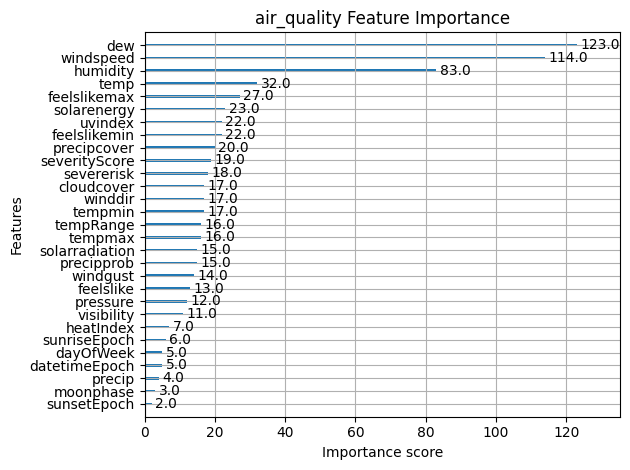

In [41]:
calculate_feature_importance(opt_air, "air_quality")

health_risk Feature Importance Chart Saved


<Figure size 1000x600 with 0 Axes>

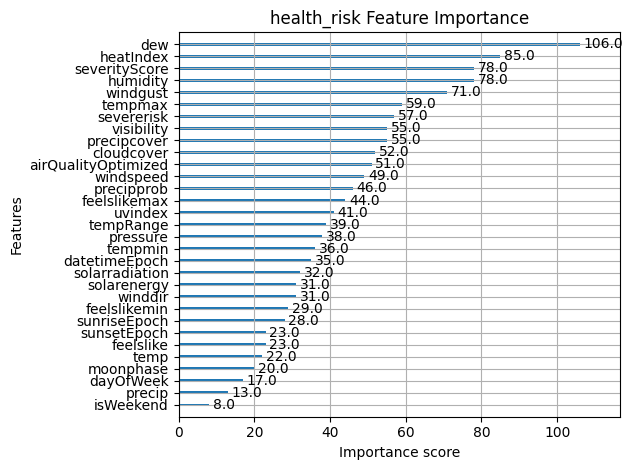

In [42]:
calculate_feature_importance(opt_health, "health_risk")

air_quality Shap Summary Chart Saved
air_quality Shap Analysis Chart Saved


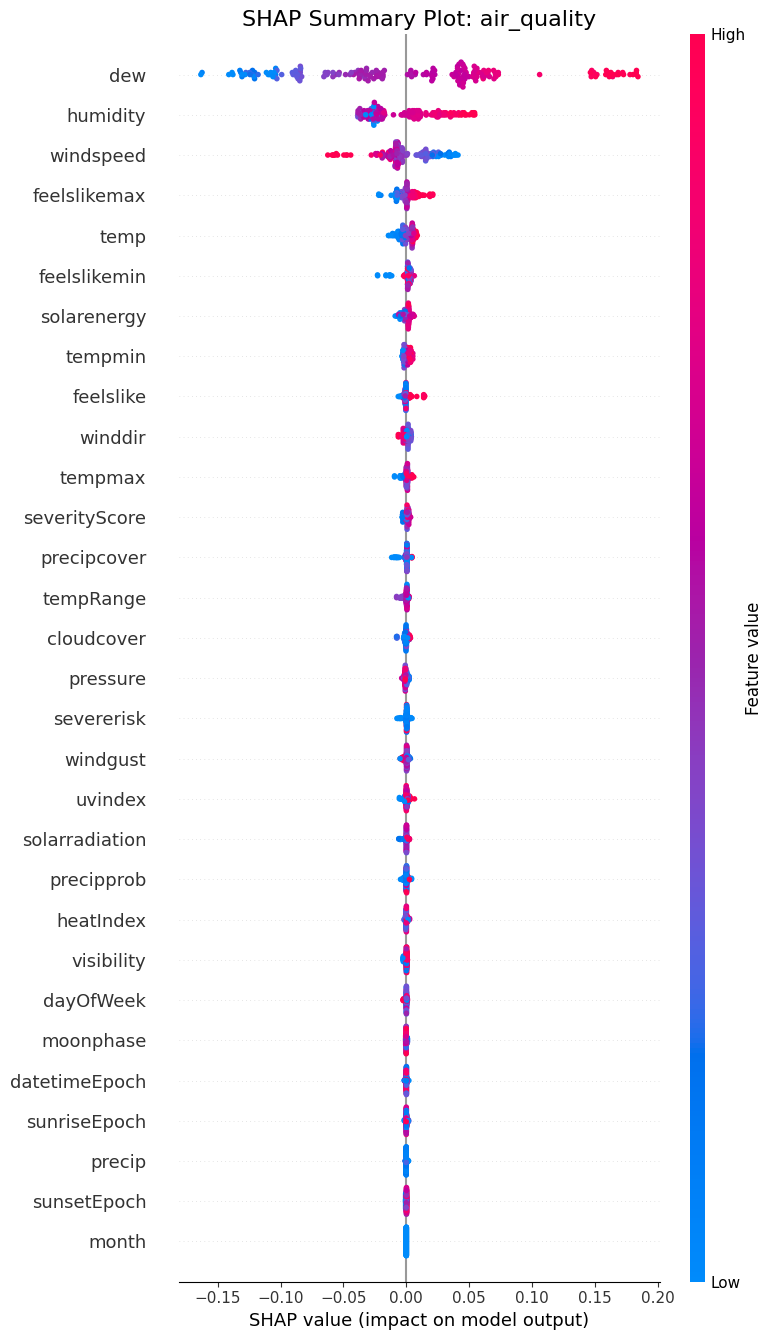

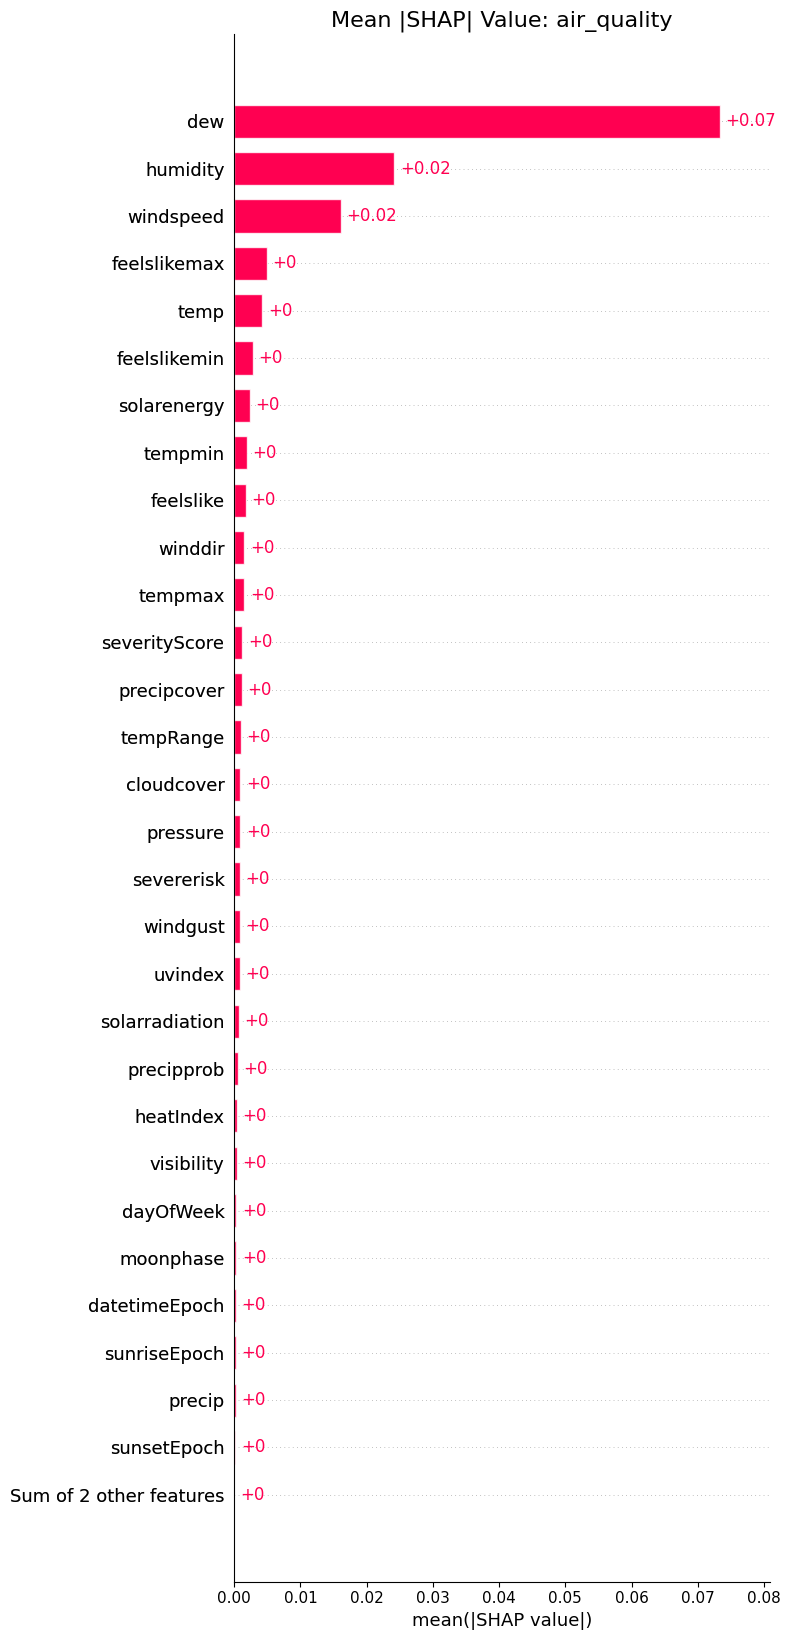

In [43]:
shap_analysis(opt_air, X_test_a, "air_quality")

health_risk Shap Summary Chart Saved
health_risk Shap Analysis Chart Saved


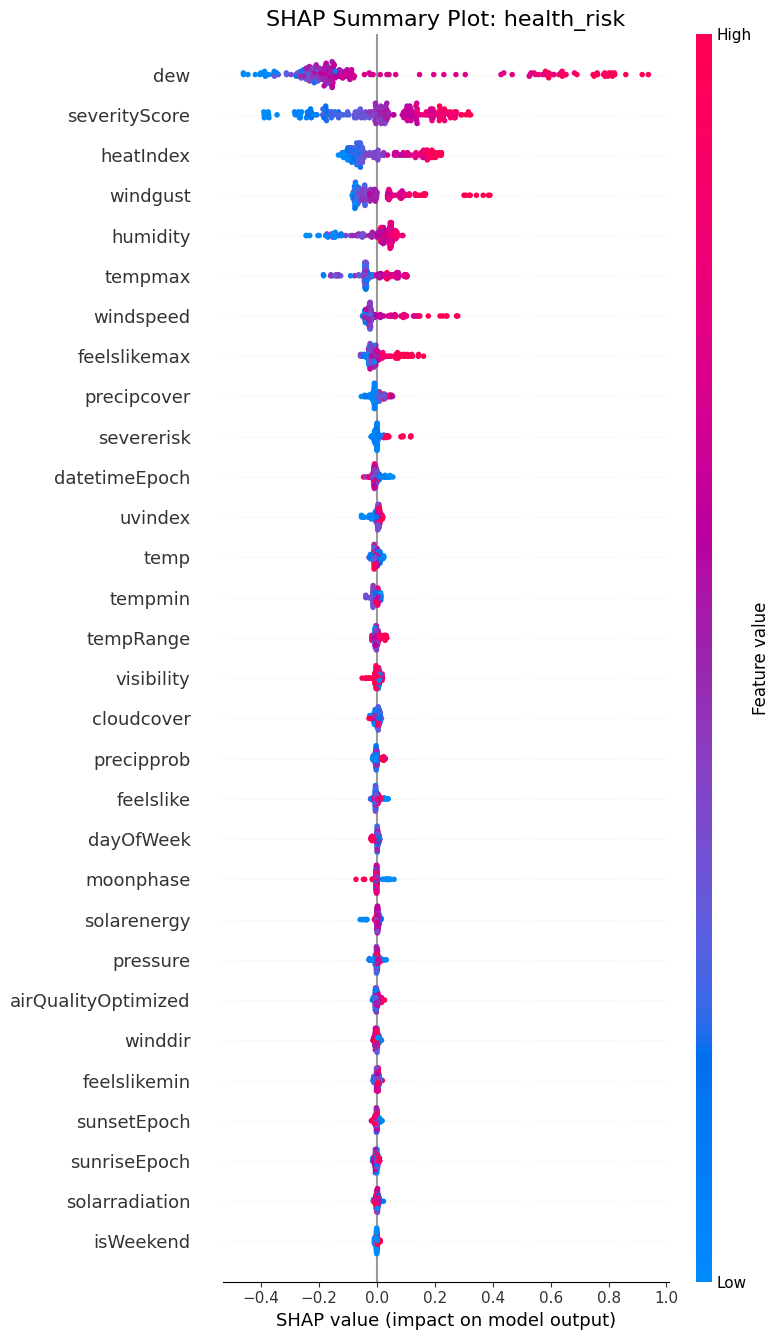

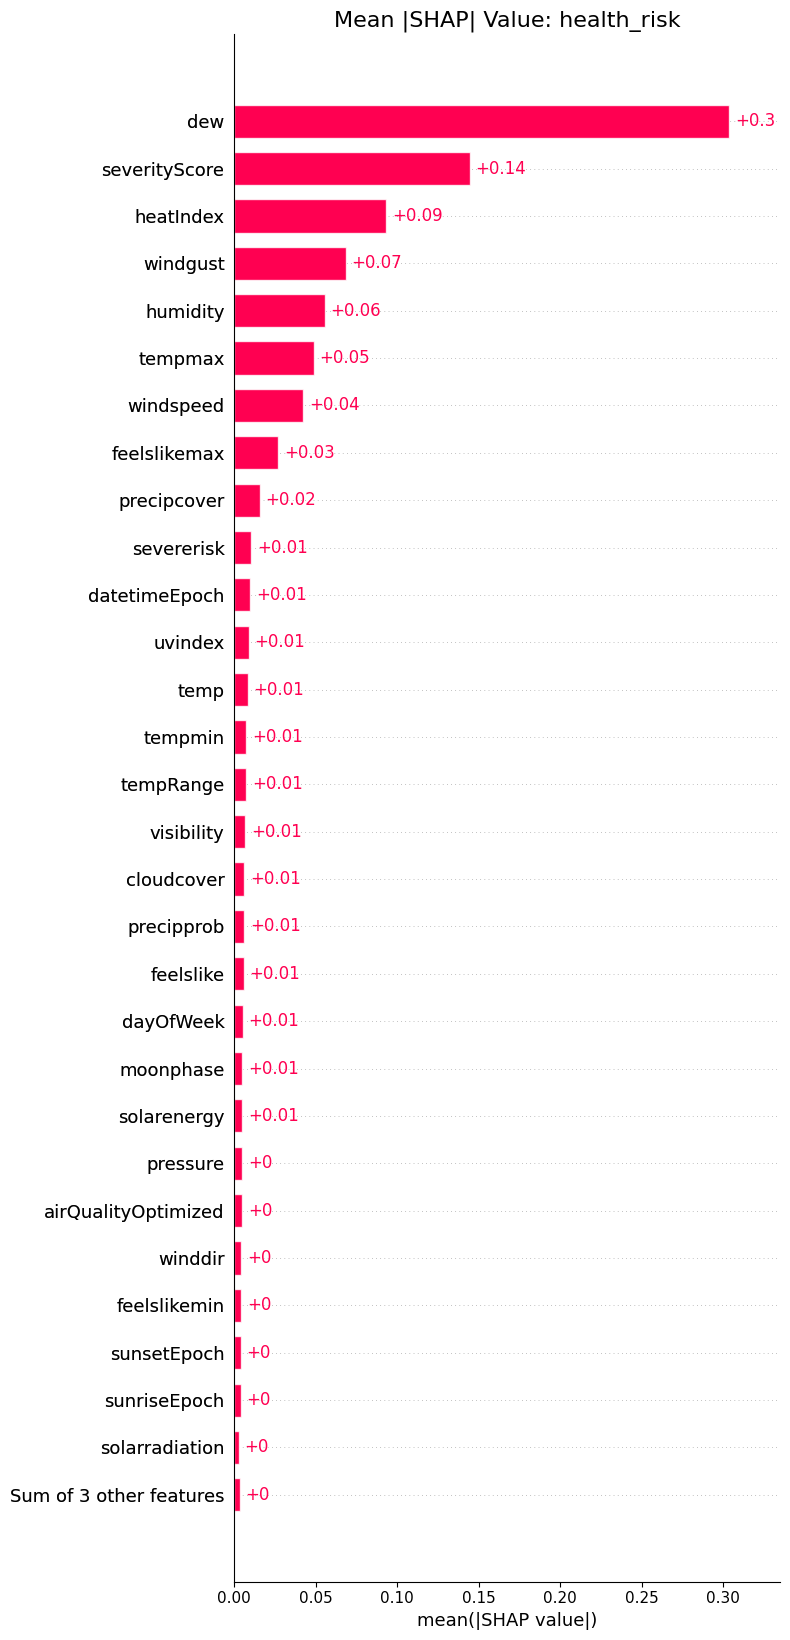

In [44]:
shap_analysis(opt_health, X_test_h, "health_risk")

## Summary and Conclusions

The optimized models achieved RMSEs of 0.06604 and 0.11242 for predicting air quality and health risk, respectively. Because RMSE is measured in the same units as the underlying values, it is helpful to examine the value ranges of the underlying features being forecasted to determine what these results indicate. The composite air quality feature I used is comprised of normalized pollutant values, so its values range from 0 to 1. The healthRiskScore feature ranges from ~8.5 to a little over 11. Given these ranges, the fact that the optimized model can predict them within, on average, 0.06 and 0.11, respectively, indicates a strong model capable of providing accurate air quality and health risk forecasts. 

Furthermore, the optimized model achieved MAPEs of 0.10720 and 0.00880 on air quality and health risk, respectively. It is a bit easier to assess these because MAPE is not dependent on the units of the measured feature. Generally, a MAPE between 10% and 20% is considered good, and a MAPE under 10% is considered excellent [16]. Based on these thresholds, the optimized model straddles the line between good and excellent when predicting air quality and is definitively excellent at forecasting health risk.

Both metrics indicate that the optimized model effectively achieves the problem statement’s goal of delivering highly accurate forecasts of air quality and health risk. Moreover, because the optimized model does not use individual pollutant features or the healthRiskScore feature when predicting air quality, it can provide accurate air quality forecasts based solely on weather data. The projected air quality can then be plugged into the model to generate a precise prediction of the health risk score for the corresponding day. Weather forecasters can leverage the model's accuracy to provide accurate air quality forecasts and recommendations to their viewers. City officials and local planners can utilize the model to develop and assess potential policies that mitigate future health risks for their citizens.

The most significant implication of this analysis is the transition from a theoretical model to a production-ready model. While the baseline model appeared to be highly accurate at forecasting air quality, this accuracy was misleading because it was a product of data leakage. Therefore, it would not have been generalizable to new data where the individual pollutant values were not known. The optimized model, while showing a higher MAPE for air quality, represents a valid forecasting tool that effectively maps weather patterns to air quality without cheating.

For entities like the Environmental Protection Agency and/or urban planners, the optimized model directly translates to actionable preventative capabilities that further the goals outlined in the problem statement, such as:

1.	**Improved Forecasting:** Because the optimized model relies solely on weather data to forecast air quality, weather forecasts can be input into the model to predict air quality days in advance. This allows for proactive measures to be taken before pollution levels spike,  preemptively addressing health crises.

2.	**Enhanced Generalization:** By adding two different types of regularization, as well as bagging, the optimized model is less likely to overfit to the training data and more capable of generalizing to new, unseen data. 

3.	**High-Confidence Alerts:** The optimized model’s exceptionally low health risk MAPE means public health officials can trust the model’s predicted health risk scores. This is crucial for establishing and maintaining public trust.

4.	**Efficiency and Scalability:** The reduction in features, combined with the use of an optimized, regularized XGBoost architecture, ensures the system is computationally efficient. This meets the problem statement’s requirement for a highly efficient predictive model, allowing it to be scaled to monitor multiple cities simultaneously without requiring excessive computational infrastructure.

In conclusion, the optimized model is more efficient, more accurate, and more trustworthy than the baseline model. Thus, it is well-equipped to provide substantial value to business stakeholders.


## Sources

[1] Brownlee, J. (2021). XGBoost for Regression. Machine Learning Mastery. https://machinelearningmastery.com/xgboost-for-regression/.

[2] Cezayirli, B. (2025). A Comprehensive Guide to Hyperparameter Tuning in XGBoost. https://barancezayirli.com/blog/ai/a-comprehensive-guide-to-hyperparameter-tuning-in-xgboost.

[3] Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. https://arxiv.org/abs/1603.02754.

[4] Hyndman, R. and Athanasopoulos, G. (2018). Forecasting: Principles and Practice. https://otexts.com/fpp2/.

[5] Wikipiedia. (Last accessed January 9, 2025). Mean absolute percentage error. https://en.wikipedia.org/wiki/Mean_absolute_percentage_error.

[6] bugfree.ai. (n.d.). Detecting and Handling Multicollinearity in Features.  https://bugfree.ai/knowledge-hub/detecting-handling-multicollinearity-features.

[7] ApX. (n.d.). Tuning the Number of Estimators and Learning Rate. https://apxml.com/courses/gettingstarted-with-gradient-boosting-algorithms/chapter-6-hyperparameter-tuning-and-optimization/tuning-estimators-and-learning-rate.

[8] Stack Exchange. (2022). What is the purpose behind tuning the n_estimators parameter in XGBoost? https://stats.stackexchange.com/questions/592936/what-is-the-purpose-behind-tuning-n-estimators-in-xgboost.

[9] Simplilearn. (2025). Bagging in Machine Learning: Step to Perform and Its Advantages. https://www.simplilearn.com/tutorials/machine-learning-tutorial/bagging-in-machine-learning.

[10] Smith, C. (2019). Penalizing Complexity. https://camtsmith.com/articles/2019-08/regularization.

[11] SoulPage. (n.d.). L1 Regularization. https://soulpageit.com/ai-glossary/l1-regularization-explained/.

[12] GeeksforGeeks. (2025). Ridge Regression. https://www.geeksforgeeks.org/machine-learning/what-is-ridge-regression/.

[13] Ravindran, R. (2023). Overfitting and Pruning in Decision Trees — Improving Model’s Accuracy. https://medium.com/nerd-for-tech/overfitting-and-pruning-in-decision-trees-improving-models-accuracy-fdbe9ecd1160.

[14] Reality Pathing. (2025). What Does Dew Reveal About Environmental Health? https://realitypathing.com/what-does-dew-reveal-about-environmental-health/.

[15] Nkomo, B. (2021). The Higgs Boson Machine Learning Challenge in the CERN Large Hadron Collider. https://brightonnkomo.medium.com/the-higgs-boson-machine-learning-challenge-in-the-cern-large-hadron-collider-8520b709686d.

[16] Kaur, G. (2024). Mastering MAPE: A Guide to Understanding and Using Mean Absolute Percentage Error. Medium. https://medium.com/@pirthipalsingh138/mastering-mape-a-guide-to-understanding-and-using-mean-absolute-percentage-error-8fd88f347eaa.